In [1]:
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
import pandas as pd
import os
import re
from rdkit import RDLogger

import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Failed to find the pandas get_adjustment() function to patch")
warnings.filterwarnings("ignore", message="Failed to patch pandas - PandasTools will have limited functionality")

# Your code here


def clean_text(text):
    return re.sub(r'\|[^|]*\|', '', text)

# Create a Path object for the current directory
current_directory = Path.cwd()

# Creating a Path object for an example file that does not yet exist
example_file_path = current_directory / "1976_Sep2016_USPTOgrants_smiles.rsmi"

# Reading the contents of the file to test if we have well acess to our data
if example_file_path.exists():
    with example_file_path.open("r") as file:
        first_line = file.readline()
else:
    print("The file does not exist.")

dataFrame= pd.read_csv("1976_Sep2016_USPTOgrants_smiles.rsmi", delimiter='\t',low_memory=False)
dataFrame = dataFrame.astype(str)
dataFrame["ReactionSmiles"] = dataFrame["ReactionSmiles"].apply(lambda x: clean_text(x))
#Delete columns that are not the reactions or the yield
columns_to_delete = ["PatentNumber", "ParagraphNum", "Year", "TextMinedYield"]
dataFrame.drop(columns=columns_to_delete, inplace=True)
#Separate the Reactants from the Products
new_columns = dataFrame['ReactionSmiles'].str.split('>', expand=True)
new_columns = new_columns.rename(columns={0: 'Reactant 1', 2 : "Product 1"})
dataFrame = pd.concat([new_columns, dataFrame.iloc[:, 1:]], axis=1)
dataFrame.drop(columns=1, inplace=True)
#Separate the reactants from each other
reactants_split = dataFrame['Reactant 1'].str.split("\.", expand = True)
reactants_split.columns = [f'Reactant {i+1}' for i in range(reactants_split.shape[1])]
dataFrame = pd.concat([reactants_split, dataFrame.iloc[:, 1:]], axis=1)
#Separate the Products from each other
products_split = dataFrame['Product 1'].str.split("\.", expand = True)
products_split.columns = [f'Product {i+1}' for i in range(products_split.shape[1])]
dataFrame = pd.concat([products_split, dataFrame.iloc[:, 1:]], axis=1)
dataFrame = dataFrame.loc[:, ~dataFrame.columns.duplicated(keep='first')]

dataFrame = dataFrame[dataFrame["CalculatedYield"] != 'nan']

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [2]:
"""
This Cell groups the functions used to clean the dataframe to be able to use it later
"""
# Remove atome mapping numbers from smiles
import re

def remove_atom_mapping(smiles):
    """
    Remove atom mapping numbers from a SMILES-like notation.
    Arguments:
    - smiles (str): The SMILES-like notation with atom mapping numbers.
    Returns:
    - smiles_without_mapping (str): The SMILES notation without atom mapping numbers.
    """
    pattern = r':\d+'
    smiles_without_mapping = re.sub(pattern, '', smiles)
    return smiles_without_mapping

dataFrame = dataFrame.astype(str)
columns_to_process = dataFrame.columns[:-1]
for column in columns_to_process:
    dataFrame[column] = dataFrame[column].apply(remove_atom_mapping)
    
#Remove the percentage symbol
def remove_percent_symbol(value):
    """
    Remove the '%' symbol from a percentage value.
    Arguments:
    - value (str): The percentage value with the '%' symbol.
    Returns:
    - value_without_percent (str): The percentage value without the '%' symbol.
    """
    return value.replace('%', '')

# Apply the remove_percent_symbol function to the "CalculatedYield" column
dataFrame['CalculatedYield'] = dataFrame['CalculatedYield'].apply(remove_percent_symbol)

In [23]:
pd.set_option('display.max_colwidth', None)
def main():
    
    while True:
        choice=input("Press Enter to get random products or type 'exit' to quit: ")
        if choice == "exit":
            print("Exiting.")
            break
        else: 
            filtered_columns = [pd.Series(dataFrame.iloc[:, i].dropna().unique()) for i in range(53)]
            selected_columns = pd.concat(filtered_columns, axis=0)
            random_products = selected_columns.sample(n=1)
            print(random_products)

        
        choice = input("Do you want to continue? (yes/no): ").strip().lower()
        if choice == "no":
            print("Exiting.")
            break
            
if __name__ == "__main__":
    main()

Press Enter to get random products or type 'exit' to quit:  


358242    [C]([O][C]([N]1[CH2][CH]=[CH][CH2][NH][C@H]([CH3])[CH2]1)=[O])([CH3])([CH3])[CH3] 
dtype: object


Do you want to continue? (yes/no):  no


Exiting.


In [24]:
# Prompt the user to enter the molecule that he wants to form
print ("you can enter the name of the molecule or its SMILES, the racemic configuration is available.")
string_input_mol = input("Enter the molecule that you want to form: ")

you can enter the name of the molecule or its SMILES, the racemic configuration is available.


Enter the molecule that you want to form:  CCSc2cccc3c(CC(=O)O)cc1ccccc1n(C)c23


In [25]:
"""
Function to determine if the user enters the SMILES notation or the usual name of the molecule.
"""
from rdkit import Chem

def is_smiles(smiles):
    """
    Check if a string represents a valid SMILES notation.
    Args:
    - smiles (str): The string to check.
    Returns:
    - is_valid (bool): True if the string is a valid SMILES notation, False otherwise.
    """
    if Chem.MolFromSmiles(smiles)== None:
        return False
    else:
        return True

# Check if the entered string is a valid SMILES notation
string_input_mol = remove_atom_mapping(string_input_mol)
if is_smiles(string_input_mol):
    print(f"'{string_input_mol}' is a valid SMILES notation.")
else:
    print(f"'{string_input_mol}' is not a valid SMILES notation.")

'CCSc2cccc3c(CC(=O)O)cc1ccccc1n(C)c23' is a valid SMILES notation.


In [26]:
"""
Function to convert name into SMILES if the input isn't in this form.
"""
import pubchempy as pcp

def name_to_smiles(molecule_name):
    """
    Convert a molecule name to a SMILES notation using PubChemPy's PubChem database.
    Args:
    - molecule_name (str): The name of the molecule.
    Returns:
    - smiles (str): The SMILES notation of the molecule, or None if retrieval fails.
    """
    try:
        compound = pcp.get_compounds(molecule_name, 'name')
        if compound:
            return compound[0].canonical_smiles
        else:
            print("Error: Unable to retrieve molecule information. Please try with the SMILE of the molecule")
            return None
    except:
        print("Error: Unable to retrieve molecule information. Please try again")
        return None

# Call the function to convert the molecule name to SMILES notation
if is_smiles(string_input_mol)== False:
    string_input_mol2 = string_input_mol
    string_input_mol = name_to_smiles(string_input_mol)
    if string_input_mol:
        print(f"SMILES notation for {string_input_mol2}: {string_input_mol}")
else:
    print (string_input_mol)

CCSc2cccc3c(CC(=O)O)cc1ccccc1n(C)c23


In [27]:
import pandas as pd
import sys

def compare_molecule_with_data(element, string_input_mol, start_col=0, end_col=None):
    return ''.join(element.split()).lower() == ''.join(string_input_mol.split()).lower()



def find_molecule_rows(dataFrame, string_input_mol, start_col=0, end_col=None):
    """
    Search through the specified range of columns in a DataFrame for the input molecule.
    
    Args:
    - dataFrame (pd.DataFrame): The DataFrame to search.
    - string_input_mol (str): The molecule to search for.
    - start_col (int): The starting column index for the search.
    - end_col (int): The ending column index for the search. If None, searches until the last column.

    Returns:
    - List[int]: A list of row indices where the molecule is found.
    """
    # Initialize a list to store the row numbers
    rows = []

    # Set end_col to the last column index if not provided
    if end_col is None:
        end_col = dataFrame.shape[1]

    # Total number of elements to check
    total_elements = (end_col - start_col) * len(dataFrame)
    current_element = 0

    # Iterate over the specified range of columns in the DataFrame
    for column_name in dataFrame.columns[start_col:end_col]:
        column = dataFrame[column_name]
        # Check if any element in the column matches the input molecule
        for index, value in column.items():
            if compare_molecule_with_data(value, string_input_mol):
                # Store the row number where the molecule is found
                rows.append(index)
            current_element += 1
            

rows = find_molecule_rows(dataFrame, string_input_mol, start_col=0, end_col=53)
if rows:
    print("Rows where the molecule is found:", rows)
else:
    print("The product is not in the database")

The product is not in the database


In [28]:
"""
This code finds the isomers (if there is ones) if the product searched isn't in the database.
"""
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

def is_isomer(smiles_given):
    if smiles_given is None :
        return "Invalid SMILES notation, please check input."
    else:
        mol1 = Chem.MolFromSmiles(smiles_given)
        #Give molecular formula
        formula1 = rdMolDescriptors.CalcMolFormula(mol1)
    
    for idx, row in dataFrame.iterrows():
        for col in dataFrame.columns:
            if "Product" in col:
                smiles2 = row[col]
                if smiles2 == "None":
                    continue
                else:
                    mol2 = Chem.MolFromSmiles(smiles2)
                    formula2 = rdMolDescriptors.CalcMolFormula(mol2)
                    if formula1 == formula2:
                        return smiles2, idx, col


if not rows :  
    choice = input("Your product isn't in the database. Do you want to look for an isomer molecule? (enter yes/no) ")
    if choice.lower() == "no":
        print("Exiting.")
    else:
        string_input_mol3 = string_input_mol
        result = is_isomer(string_input_mol)
        if result == None:
            print ("No isomer of the input was found in the database, sorry :(.")
        else:
            string_input_mol, idx, col = result
            rows = [idx]
            print(f"The isomer found for {string_input_mol3} is {string_input_mol}, the program will continue with the latter.")



Your product isn't in the database. Do you want to look for an isomer molecule? (enter yes/no)  yes


The isomer found for CCSc2cccc3c(CC(=O)O)cc1ccccc1n(C)c23 is [CH2]([S][C]1[CH]=[CH][C]2[N]([CH3])[C]3[CH]=[CH][CH]=[CH][C]=3[CH]=[C]([CH2][C]([OH])=[O])[C]=2[CH]=1)[CH3] , the program will continue with the latter.


In [29]:
"""
This code prints the yield and shows the image of the reaction corresponding
"""
import numpy as np
# Convert the 'Yield' column to float
dataFrame['CalculatedYield'] = dataFrame['CalculatedYield'].astype(float)
# Subset the DataFrame to include only the specified rows
subset_df = dataFrame.loc[rows]
max_yield_row_index = subset_df['CalculatedYield'].idxmax()
# Retrieve the row with the highest yield
max_yield_row = dataFrame.loc[max_yield_row_index]
print("Row with the highest yield:")
print(max_yield_row)

# print the reaction
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
#Create a Dataframe where the reaction is in one column
dataFrameImage= pd.read_csv("1976_Sep2016_USPTOgrants_smiles.rsmi", delimiter='\t',low_memory=False)
columns_to_delete = ["PatentNumber", "ParagraphNum", "Year", "TextMinedYield"]
dataFrameImage.drop(columns=columns_to_delete, inplace=True)
dataFrameImage["ReactionSmiles"] = dataFrameImage["ReactionSmiles"].apply(remove_atom_mapping)
# Create a reaction SMILES string
reaction_smiles = dataFrameImage.iloc[max_yield_row_index, 0]
# Parse the reaction SMILES string
reaction = Chem.AllChem.ReactionFromSmarts(reaction_smiles)
# Draw the reaction
reaction_image = Draw.ReactionToImage(reaction)

# Save or display the image
reaction_image.show()

Row with the highest yield:
Product 1          [CH2]([S][C]1[CH]=[CH][C]2[N]([CH3])[C]3[CH]=[CH][CH]=[CH][C]=3[CH]=[C]([CH2][C]([OH])=[O])[C]=2[CH]=1)[CH3] 
Product 2                                                                                                                   None
Product 3                                                                                                                   None
Product 4                                                                                                                   None
Product 5                                                                                                                   None
                                                                       ...                                                      
Reactant 58                                                                                                                 None
Reactant 59                                                          

Unable to retrieve molecule name.
The Molecular weight of the product is 325.43300000000005.


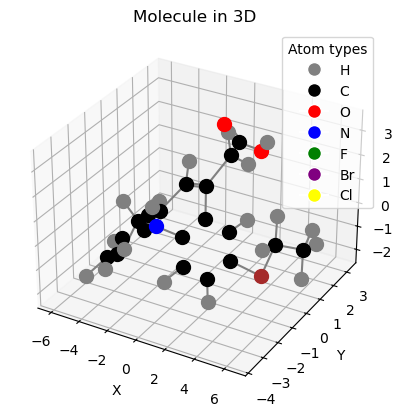

In [30]:
"Informations about the product that we want to form"

#name of the molecule

from chemspipy import ChemSpider

def get_molecule_name(smiles):
    """
    Get the common name of a molecule from its SMILES representation using ChemSpider.
    Args:
    - smiles (str): SMILES representation of the molecule.
    Returns:
    - name (str): Common name of the molecule.
    """
    cs = ChemSpider('your_api_key_here') 
    results = cs.simple_search(smiles)
    if results:
        return results[0].common_name
    else:
        return "Unable to retrieve molecule name."

print (get_molecule_name(string_input_mol))

# To print the molecular weight
from rdkit import Chem
from rdkit.Chem import Descriptors

def get_molecular_weight(smiles):
    """
    Calculate the molecular weight of a molecule given its SMILES string.
    
    Args:
    smiles (str): SMILES string of the molecule.
    
    Returns:
    float: Molecular weight of the molecule.
    """
    # Convert the SMILES string to an RDKit molecule object
    molecule = Chem.MolFromSmiles(smiles)
    
    # Check if the molecule is valid
    if molecule is None:
        raise ValueError("Invalid SMILES string provided")
    
    # Calculate the molecular weight
    molecular_weight = Descriptors.MolWt(molecule)
    
    return molecular_weight

print (f"The Molecular weight of the product is {get_molecular_weight(string_input_mol)}.")

#3D representation of the molecule

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def plot_molecule_3D(smiles):
    """
    Plot a molecule in 3D with different colors for different types of atoms and bonds between atoms.
    Args:
    - smiles (str): SMILES representation of the molecule.
    """
    # Generate RDKit molecule from SMILES
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print("Error: Unable to generate molecule from SMILES.")
        return
    
    # Add explicit hydrogens
    mol = Chem.AddHs(mol)

    # Generate 3D coordinates
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)

    # Extract atom coordinates and symbols
    coords = mol.GetConformer().GetPositions()
    symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]

    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Define colors for different atom types
    atom_colors = {'H': 'gray', 'C': 'black', 'O': 'red', 'N': 'blue', 'F': 'green', 'Br': 'purple', 'Cl': 'yellow'}

    # Plot atoms with different colors
    for atom_idx, symbol in enumerate(symbols):
        x, y, z = coords[atom_idx]
        color = atom_colors.get(symbol, 'brown')  # Default to brown for unknown atoms
        ax.scatter(x, y, z, c=color, label=symbol, s=100)

    # Helper function to plot bonds
    def plot_bond(ax, start_pos, end_pos, offset=np.array([0, 0, 0])):
        ax.plot([start_pos[0] + offset[0], end_pos[0] + offset[0]], 
                [start_pos[1] + offset[1], end_pos[1] + offset[1]], 
                [start_pos[2] + offset[2], end_pos[2] + offset[2]], c='gray')

    # Plot bonds between atoms with different styles for single and double bonds
    for bond in mol.GetBonds():
        start_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        start_pos = coords[start_idx]
        end_pos = coords[end_idx]
        bond_type = bond.GetBondType()
        
        if bond_type == Chem.rdchem.BondType.SINGLE:
            plot_bond(ax, start_pos, end_pos)
        elif bond_type == Chem.rdchem.BondType.DOUBLE:
            # Calculate an offset direction perpendicular to the bond
            bond_vector = end_pos - start_pos
            normal_vector = np.cross(bond_vector, np.array([1, 0, 0]))
            if np.linalg.norm(normal_vector) < 1e-3:
                normal_vector = np.cross(bond_vector, np.array([0, 1, 0]))
            normal_vector /= np.linalg.norm(normal_vector)  # Normalize the vector
            offset = normal_vector * 0.125
            plot_bond(ax, start_pos, end_pos, offset)
            plot_bond(ax, start_pos, end_pos, -offset)

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Molecule in 3D')

    # Show legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color, label=symbol)
               for symbol, color in atom_colors.items()]
    ax.legend(handles=handles, title='Atom types', loc='best')

    # Show plot
    plt.show()

plot_molecule_3D(string_input_mol)
